

  Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

  Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?


In [1]:
!pip install stop-words pymorphy2

In [2]:
#предобработка
from string import punctuation

from pymorphy2 import MorphAnalyzer
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
max_words = 2000
max_len = 10
num_classes = 1

epochs = 10
batch_size = 512
print_batch_n = 100

In [4]:
dataset_train  = 'C:/Ангелина/Data Sience/4 четверть/PyTorch/6/train.csv'
dataset_test  = 'C:/Ангелина/Data Sience/4 четверть/PyTorch/6/test.csv'
data_train = pd.read_csv(dataset_train, encoding='utf-8')
data_test = pd.read_csv(dataset_test, encoding='utf-8')
data_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
data_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [6]:
df_train, df_valid = train_test_split(data_train, test_size=0.3, random_state=42)
df_train.head()

,id,label,tweet
9635,9636,0,summer timeð #summeriscoming #swimming #pic...
2447,2448,0,"dese niggas will show dese otha bitches on fb,..."
16134,16135,0,"""when you are you boost your immune system a..."
18393,18394,0,reading my manuscript and not wanting to stop....
4420,4421,0,baby says he hates me today


In [7]:
df_valid.head()

,id,label,tweet
12227,12228,0,@user âmy mom says my smile is captivatingâ...
14709,14710,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,19320,0,hating the conservative homophobes using this ...
4308,4309,0,awee if this doesn't #scream #friday #acewe...
24055,24056,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...


In [8]:
sw = set(stopwords.words('english'))
print(sw)

{'does', "aren't", "hasn't", 'you', 'i', 'same', 'needn', 'my', 'theirs', 'is', 'me', 'did', 's', 'yourselves', 'll', 'didn', 'now', "don't", 'was', 'its', 'an', 'wouldn', 'were', 'few', "haven't", 'ain', 'can', "you've", 'how', 'from', 'these', 'more', 'before', 'shan', 'yourself', 'am', 'nor', 'themselves', 're', "hadn't", "shouldn't", 'him', 'has', 'yours', 'for', 'doing', 'o', 'at', 'some', 'do', 'hasn', 'by', 'about', "didn't", 'whom', 'until', 'then', "doesn't", 'our', 'who', 'no', 'over', 'of', 'out', 'are', 'while', 'so', 'doesn', 'such', 'most', 'will', 'we', 'don', 'mustn', "she's", 'there', "won't", 'other', 'further', 'aren', 'should', "wasn't", 'the', 'himself', 'between', 'hers', 'itself', 'up', 'again', 'haven', 'under', 've', 'against', 'ourselves', 'not', 'very', 'during', "you'd", 'just', 'your', 'this', 'ours', 'because', 'shouldn', 'which', 'weren', 'what', 'hadn', 'through', 'be', 'too', 'all', 'those', 'herself', "that'll", 'in', 'ma', 'below', 'once', "you'll", "

In [9]:
exclude = set(punctuation)
print(exclude)

{'*', '[', '(', '<', ':', '}', ']', '\\', '!', '~', '#', ';', "'", '.', '?', '^', '/', '$', '>', '{', '`', '=', '%', ')', '-', '@', '"', '_', '&', '|', ',', '+'}


In [10]:
#морфологический анализ для английского текста
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('donkeys'), lemmatizer.lemmatize('runs')

('donkey', 'run')

In [11]:
#функция преобразования текста
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [lemmatizer.lemmatize(w) for w in txt.split() if w not in sw]
    return " ".join(txt)

In [12]:
#преобразование текста в данных
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_valid['tweet'] = df_valid['tweet'].progress_apply(preprocess_text)
data_test['tweet'] = data_test['tweet'].progress_apply(preprocess_text)

100%|█████████████████████████████████████████████████████████████████████████| 22373/22373 [00:01<00:00, 16008.62it/s]
C:\Users\User\AppData\Local\Temp/ipykernel_79616/1309153931.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
100%|███████████████████████████████████████████████████████████████████████████| 9589/9589 [00:00<00:00, 16452.97it/s]
C:\Users\User\AppData\Local\Temp/ipykernel_79616/1309153931.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [13]:
#соединение всех обучающих данных в одну строку и приведение к нижнему регистру
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()
#токенизация
tokens = word_tokenize(train_corpus)
tokens[:10]

['summer',
 'timeð\x9f\x8c',
 'summeriscoming',
 'swimming',
 'picoftheday',
 'tattoo',
 'issho',
 'pulsera',
 'fluyendo',
 'â\x80¦']

In [14]:
#отфильтруем
tokens_filtered = [word for word in tokens if word.isalnum()]

In [15]:
#частотное распределение: как часто встречается каждый токен в tokens_filtered
dist = FreqDist(tokens_filtered)
dist

FreqDist({'user': 12209, 'love': 1886, 'day': 1875, 'happy': 1183, 'u': 1161, 'amp': 1099, 'time': 851, 'life': 844, 'im': 785, 'today': 742, ...})

In [16]:
#(создаем упорядоченные пары (слово, частота) в количестве max_words штук и берем первые элементы пар)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # -1 - padding
len(tokens_filtered_top), tokens_filtered_top[:10]

(1999,
 ['user', 'love', 'day', 'happy', 'u', 'amp', 'time', 'life', 'im', 'today'])

In [17]:
#слово : индекс из tokens_filtered_top
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top)).items()}

In [18]:
#преобразование текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())  #токенизация
    tokens_filtered = [word for word in tokens if word.isalnum()] #фильтруем (только буквы и цифры)
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word]) #если слово в топе токенов, то добавляем его индекс в результат

    padding = [0] * (maxlen-len(result)) #нули дополняющие до maxlen
    return result[-maxlen:] + padding

In [19]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_valid = np.asarray([text_to_sequence(text, max_len) for text in df_valid["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in data_test["tweet"]])

x_train.shape, x_valid.shape, x_test.shape

((22373, 10), (9589, 10), (17197, 10))

In [20]:
torch.from_numpy(x_train[0])

tensor([  39, 1093,  580, 1375,    0,    0,    0,    0,    0,    0],
       dtype=torch.int32)

In [21]:
#Dataset
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() #преобразуем в целочисленный тензор
        self.target = torch.from_numpy(target).long() #преобразуем в целочисленный тензор
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]  #индексация данных
        y = self.target[index]  #индексация целевой переменной
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)


In [22]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(x_valid, df_valid['label'].values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [23]:
for x, l in train_loader:
    print(x.shape, x[0])
    print(l.shape, l[0])
    break

torch.Size([512, 10]) tensor([   0,    0,    0,  411,   57,  110,  222,  466, 1042,    0])
torch.Size([512]) tensor(0)


In [24]:
#построим сеть
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes = 1):
        super().__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.dp_one(output)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.dp_two(output)
        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [25]:
model = Net(vocab_size=max_words)
print(model)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)


In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [27]:
#обучение

model.train()
th = 0.5

train_loss_history = []
valid_loss_history = []

for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        
        # обучение
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
       
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 150 batches
            model.eval()
            
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {loss:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            train_loss_history.append(loss)

            # выводим статистику на тестовых данных
            test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
            for j, data in enumerate(valid_loader):
                test_labels = data[1]
                test_outputs = model(data[0])
                
                # подсчет ошибки на тесте
                test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
                # подсчет метрики на тесте
                test_running_total += len(data[1])
                pred_test_labels = torch.squeeze((test_outputs > th).int())
                test_running_right += (test_labels == pred_test_labels).sum()
            
            valid_loss_history.append(test_loss.item())
            print(f'Val loss: {test_loss:.3f}. Val acc: {test_running_right / test_running_total:.3f}')
        
        model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/44]. Loss: 0.681. Acc: 0.676. Val loss: 1.046. Val acc: 0.929
Epoch [2/10]. Step [1/44]. Loss: 0.188. Acc: 0.924. Val loss: 0.026. Val acc: 0.929
Epoch [3/10]. Step [1/44]. Loss: 0.136. Acc: 0.955. Val loss: 0.324. Val acc: 0.938
Epoch [4/10]. Step [1/44]. Loss: 0.138. Acc: 0.943. Val loss: 0.077. Val acc: 0.944
Epoch [5/10]. Step [1/44]. Loss: 0.082. Acc: 0.967. Val loss: 0.319. Val acc: 0.947
Epoch [6/10]. Step [1/44]. Loss: 0.072. Acc: 0.975. Val loss: 0.000. Val acc: 0.945
Epoch [7/10]. Step [1/44]. Loss: 0.057. Acc: 0.984. Val loss: 0.011. Val acc: 0.945
Epoch [8/10]. Step [1/44]. Loss: 0.045. Acc: 0.982. Val loss: 0.080. Val acc: 0.945
Epoch [9/10]. Step [1/44]. Loss: 0.057. Acc: 0.982. Val loss: 0.004. Val acc: 0.942
Epoch [10/10]. Step [1/44]. Loss: 0.059. Acc: 0.980. Val loss: 0.000. Val acc: 0.946
Training is finished!


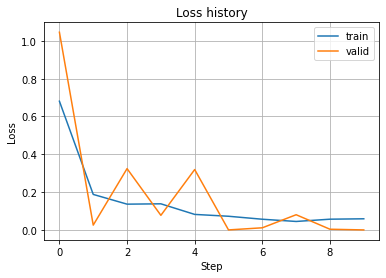

In [28]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

#### Увеличение количества слов в словаре ведет к увеличению ошибки на тесте. При этом уменьшение количества последовательности не исправляет ситуацию.
#### Уменьшение количества слоев в словаре и уменьшение постедовательности дает нестабильную метрику ошибки, но в результате, ошибка маленькая, точность высокая.
#### Увеличение количества эпох не приводит к улучшению метрики.
#### При добавлении слоев Dropout и увеличении шага градиента, метрики стали более монотонные, стремящиеся к идеальным.


